<h1 style="text-align:center; text-size:26px; font-family:'Times New Roman', Times, serif;">
  Netflix Data: Cleaning, Analysis and Visualization
</h1>


In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import statsmodels.api as sm
import altair as alt
import missingno as msno
import plotly.express as px
from wordcloud import WordCloud
from tabulate import tabulate
from matplotlib import rcParams

In [189]:
df = pd.read_csv('netflix1.csv')

In [190]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB
None


In [191]:
print(df.describe())

       release_year
count   8790.000000
mean    2014.183163
std        8.825466
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2019.000000
max     2021.000000


<h2 style="font-family:'Times New Roman', Times, serif;">
 Data Cleaning 
</h2>


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Displaying raw data 
</h3>


In [192]:
display(df.head().style.set_properties(**{'border': '1px solid black'}))

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure"
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Filling Missing Values 
</h3>


In [216]:

df.replace('', np.nan, inplace=True)


df['director'] = df['director'].fillna('Unknown Director')
df['country'] = df['country'].fillna('Unknown Country')


display(df.isnull().sum().to_frame('Missing Values').style.set_properties(**{'border': '1px solid black'}))

,Missing Values
show_id,0
type,0
title,0
director,0
country,0
date_added,0
release_year,0
rating,0
duration,0
listed_in,0


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Splitting the dates 
</h3>


In [194]:
# Convert date_added to datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Display results with grid
display(df[['date_added']].head().style.set_properties(**{'border': '1px solid black'}))
display(df.dtypes.to_frame('Data Types').style.set_properties(**{'border': '1px solid black'}))

,date_added
0,2021-09-25 00:00:00
1,2021-09-24 00:00:00
2,2021-09-24 00:00:00
3,2021-09-22 00:00:00
4,2021-09-24 00:00:00


,Data Types
show_id,object
type,object
title,object
director,object
country,object
date_added,datetime64[ns]
release_year,int64
rating,object
duration,object
listed_in,object


In [195]:

df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month_name()

display(df[['date_added', 'year_added', 'month_added']].head().style.set_properties(**{'border': '1px solid black'}))

,date_added,year_added,month_added
0,2021-09-25 00:00:00,2021,September
1,2021-09-24 00:00:00,2021,September
2,2021-09-24 00:00:00,2021,September
3,2021-09-22 00:00:00,2021,September
4,2021-09-24 00:00:00,2021,September


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
 Splitting the Genres 
</h3>


In [196]:
# Split genres
genres_split = df['listed_in'].str.split(', ', expand=True)
genres_split.columns = [f'genre_{i+1}' for i in range(genres_split.shape[1])]

# Combine with main dataframe
df = pd.concat([df, genres_split], axis=1)

# Display results with grid
display(df[['listed_in', 'genre_1', 'genre_2', 'genre_3']].head().style.set_properties(**{'border': '1px solid black'}))

,listed_in,genre_1,genre_2,genre_3
0,Documentaries,Documentaries,None,None
1,"Crime TV Shows, International TV Shows, TV Action & Adventure",Crime TV Shows,International TV Shows,TV Action & Adventure
2,"TV Dramas, TV Horror, TV Mysteries",TV Dramas,TV Horror,TV Mysteries
3,"Children & Family Movies, Comedies",Children & Family Movies,Comedies,None
4,"Dramas, Independent Movies, International Movies",Dramas,Independent Movies,International Movies


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
 Spliting the Durations
</h3>


In [197]:
# Split duration
df[['duration_num', 'duration_unit']] = df['duration'].str.split(' ', expand=True)
df['duration_num'] = pd.to_numeric(df['duration_num'])


df['duration_min'] = np.where(df['type'] == 'Movie', df['duration_num'], np.nan)
df['duration_seasons'] = np.where(df['type'] == 'TV Show', df['duration_num'], np.nan)


display(df[['duration', 'duration_num', 'duration_unit', 'duration_min', 'duration_seasons']]
        .head(10)
        .style.set_properties(**{'border': '1px solid black'}))

,duration,duration_num,duration_unit,duration_min,duration_seasons
0,90 min,90,min,90.000000,nan
1,1 Season,1,Season,nan,1.000000
2,1 Season,1,Season,nan,1.000000
3,91 min,91,min,91.000000,nan
4,125 min,125,min,125.000000,nan
5,9 Seasons,9,Seasons,nan,9.000000
6,104 min,104,min,104.000000,nan
7,87 min,87,min,87.000000,nan
8,127 min,127,min,127.000000,nan
9,76 min,76,min,76.000000,nan


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Displaying the final info 
</h3>


In [198]:
# Display final info
display(df.info())
display(df.head().style.set_properties(**{'border': '1px solid black'}))

df.to_excel('netflix_cleaned.xlsx', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   show_id           8790 non-null   object        
 1   type              8790 non-null   object        
 2   title             8790 non-null   object        
 3   director          8790 non-null   object        
 4   country           8790 non-null   object        
 5   date_added        8790 non-null   datetime64[ns]
 6   release_year      8790 non-null   int64         
 7   rating            8790 non-null   object        
 8   duration          8790 non-null   object        
 9   listed_in         8790 non-null   object        
 10  year_added        8790 non-null   int32         
 11  month_added       8790 non-null   object        
 12  genre_1           8790 non-null   object        
 13  genre_2           6778 non-null   object        
 14  genre_3           3726 n

None

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,year_added,month_added,genre_1,genre_2,genre_3,duration_num,duration_unit,duration_min,duration_seasons
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25 00:00:00,2020,PG-13,90 min,Documentaries,2021,September,Documentaries,None,None,90,min,90.000000,nan
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24 00:00:00,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure",2021,September,Crime TV Shows,International TV Shows,TV Action & Adventure,1,Season,nan,1.000000
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24 00:00:00,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",2021,September,TV Dramas,TV Horror,TV Mysteries,1,Season,nan,1.000000
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22 00:00:00,2021,TV-PG,91 min,"Children & Family Movies, Comedies",2021,September,Children & Family Movies,Comedies,None,91,min,91.000000,nan
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24 00:00:00,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",2021,September,Dramas,Independent Movies,International Movies,125,min,125.000000,nan


<h2 style="font-family:'Times New Roman', Times, serif;">
  Exploratory Data Analysis
</h2>


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  How has Netflix’s content library grown over the years?
</h3>


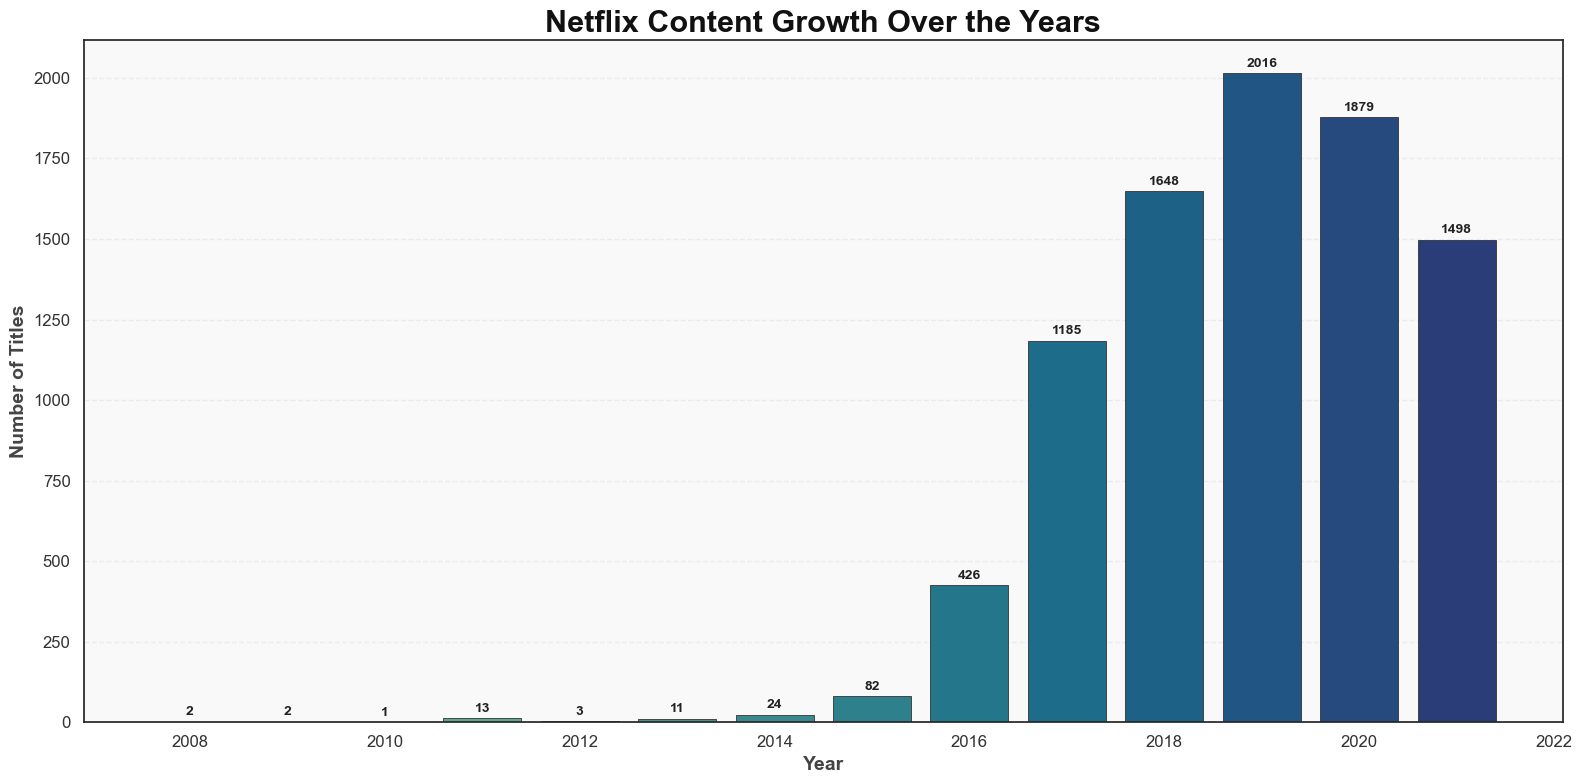

In [199]:

content_by_year = df[df['year_added'] >= 2008]['year_added'].value_counts().sort_index()
years = content_by_year.index
counts = content_by_year.values

colors = sns.color_palette("crest", n_colors=len(years))  

sns.set(style="white", rc={"axes.facecolor": "#f9f9f9"})
plt.figure(figsize=(16, 8))

bars = plt.bar(years, counts, color=colors, edgecolor="#333", linewidth=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 10,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color='#222'
    )

plt.title("Netflix Content Growth Over the Years", fontsize=22, fontweight='bold', color="#111")
plt.xlabel("Year", fontsize=14, fontweight='bold', color="#444")
plt.ylabel("Number of Titles", fontsize=14, fontweight='bold', color="#444")
plt.xticks(fontsize=12, color="#333")
plt.yticks(fontsize=12, color="#333")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()


plt.show()



<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Which countries produce the most content on Netflix?
</h3>


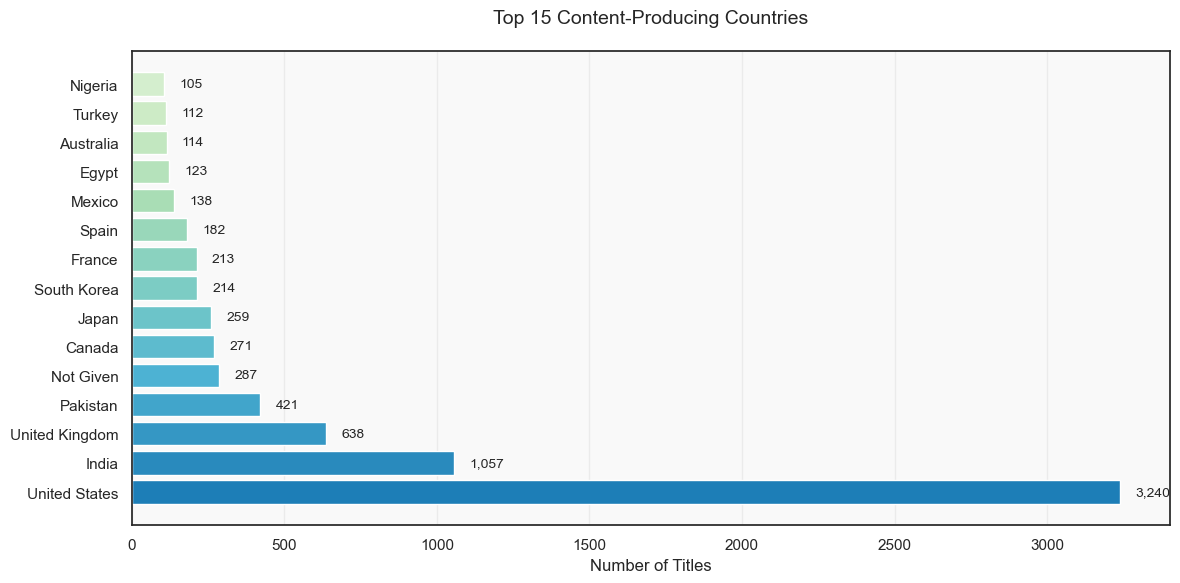

In [200]:
import matplotlib.pyplot as plt
import pandas as pd

# Clean country data (handle multiple countries per title)
df['primary_country'] = df['country'].str.split(',').str[0].str.strip()

# Get top 15 countries
top_countries = df['primary_country'].value_counts().head(15)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(top_countries.index, top_countries.values, 
               color=plt.cm.GnBu_r(np.linspace(0.2, 0.8, 15)),
               edgecolor='white')

# Annotate
for bar in bars:
    width = bar.get_width()
    plt.text(width+50, bar.get_y()+0.4, f'{width:,}',
            va='center', fontsize=10)

plt.title('Top 15 Content-Producing Countries', pad=20, fontsize=14)
plt.xlabel('Number of Titles')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  What’s the ratio of Movies to TV Shows over the years? Is Netflix focusing more on one type?
</h3>


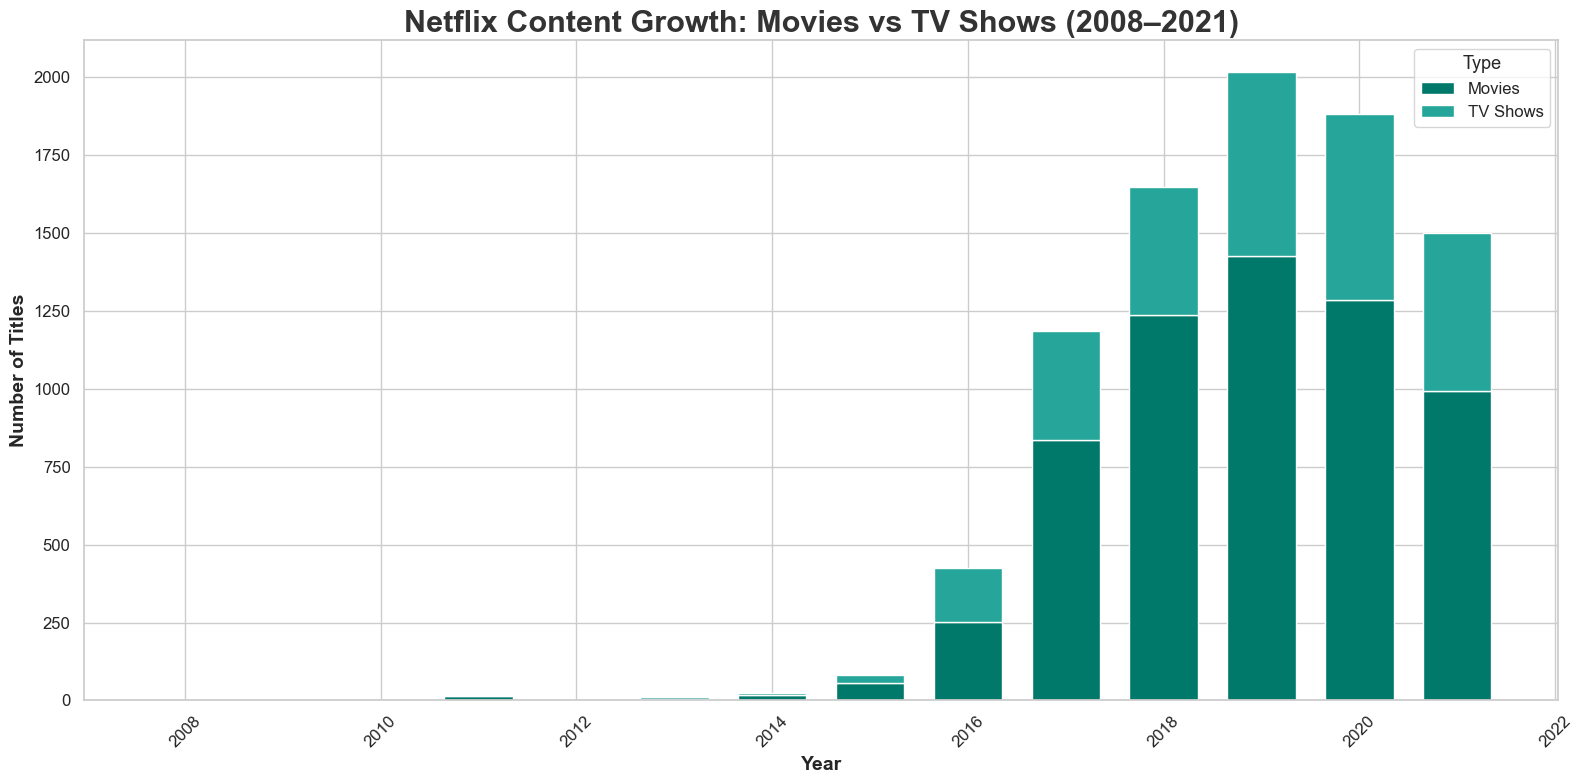

In [201]:

type_year = df[df['year_added'] >= 2008].groupby(['year_added', 'type']).size().unstack().fillna(0)

sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

colors = {
    'Movie': '#00786A',     # soft salmon pink
    'TV Show': '#26A69A'    # soft lavender purple
}

plt.bar(
    type_year.index,
    type_year['Movie'],
    label='Movies',
    color=colors['Movie'],
    width=0.7
)

plt.bar(
    type_year.index,
    type_year['TV Show'],
    bottom=type_year['Movie'],
    label='TV Shows',
    color=colors['TV Show'],
    width=0.7
)

plt.title("Netflix Content Growth: Movies vs TV Shows (2008–2021)", fontsize=22, fontweight='bold', color='#333')
plt.xlabel("Year", fontsize=14, fontweight='bold')
plt.ylabel("Number of Titles", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title="Type", fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
 Which are the most common genres? Are there any emerging genres in recent years?
</h3>


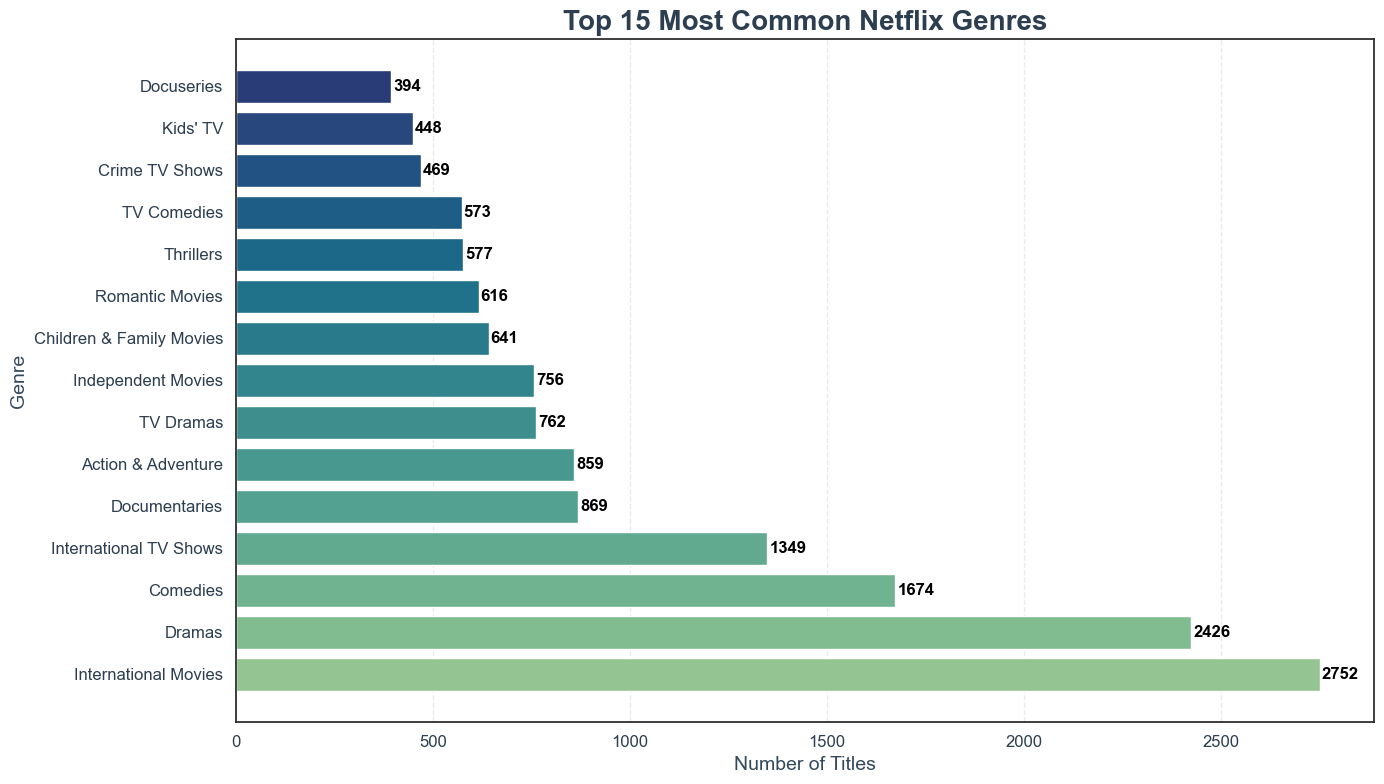

In [202]:

all_genres = df[['genre_1', 'genre_2', 'genre_3']].values.ravel()
all_genres = pd.Series(all_genres).dropna()
genre_counts = all_genres.value_counts().head(15)


colors = sns.color_palette("crest", n_colors=len(genre_counts))

plt.figure(figsize=(14, 8))
sns.set_style("white")

bars = plt.barh(genre_counts.index, genre_counts.values, color=colors)

for i, v in enumerate(genre_counts.values):
    plt.text(v + 5, i, str(v), color='black', va='center', fontweight='bold')

plt.title("Top 15 Most Common Netflix Genres", fontsize=20, fontweight='bold', color='#2C3E50')
plt.xlabel("Number of Titles", fontsize=14, color='#34495E')
plt.ylabel("Genre", fontsize=14, color='#34495E')
plt.xticks(fontsize=12, color='#2C3E50')
plt.yticks(fontsize=12, color='#2C3E50')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  What’s the average duration of Movies? Is there a trend of shorter/longer movies?
</h3>


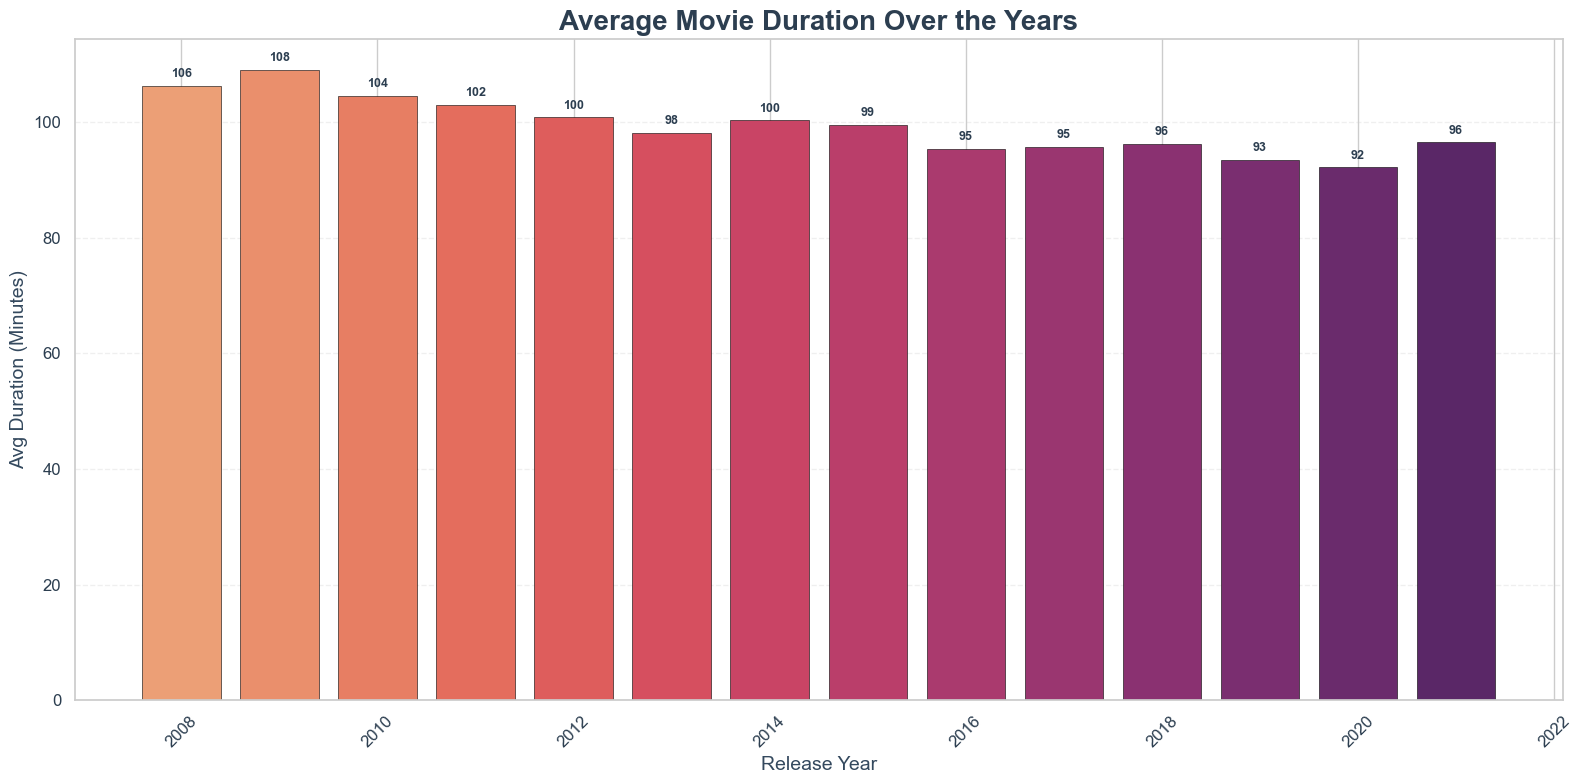

In [203]:

movies_df = df[df['type'] == 'Movie'].dropna(subset=['duration_min'])

avg_duration = movies_df.groupby('release_year')['duration_min'].mean().reset_index()
avg_duration = avg_duration[avg_duration['release_year'] >= 2008]

plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")
colors = sns.color_palette("flare", len(avg_duration)) 
bars = plt.bar(
    avg_duration['release_year'],
    avg_duration['duration_min'],
    color=colors,
    edgecolor='black',
    linewidth=0.4
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=9, fontweight='bold', color='#2C3E50')

plt.title("Average Movie Duration Over the Years", fontsize=20, fontweight='bold', color='#2C3E50')
plt.xlabel("Release Year", fontsize=14, color='#34495E')
plt.ylabel("Avg Duration (Minutes)", fontsize=14, color='#34495E')
plt.xticks(rotation=45, fontsize=12, color='#2C3E50')
plt.yticks(fontsize=12, color='#2C3E50')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Which months/years had the highest number of content additions?
</h3>


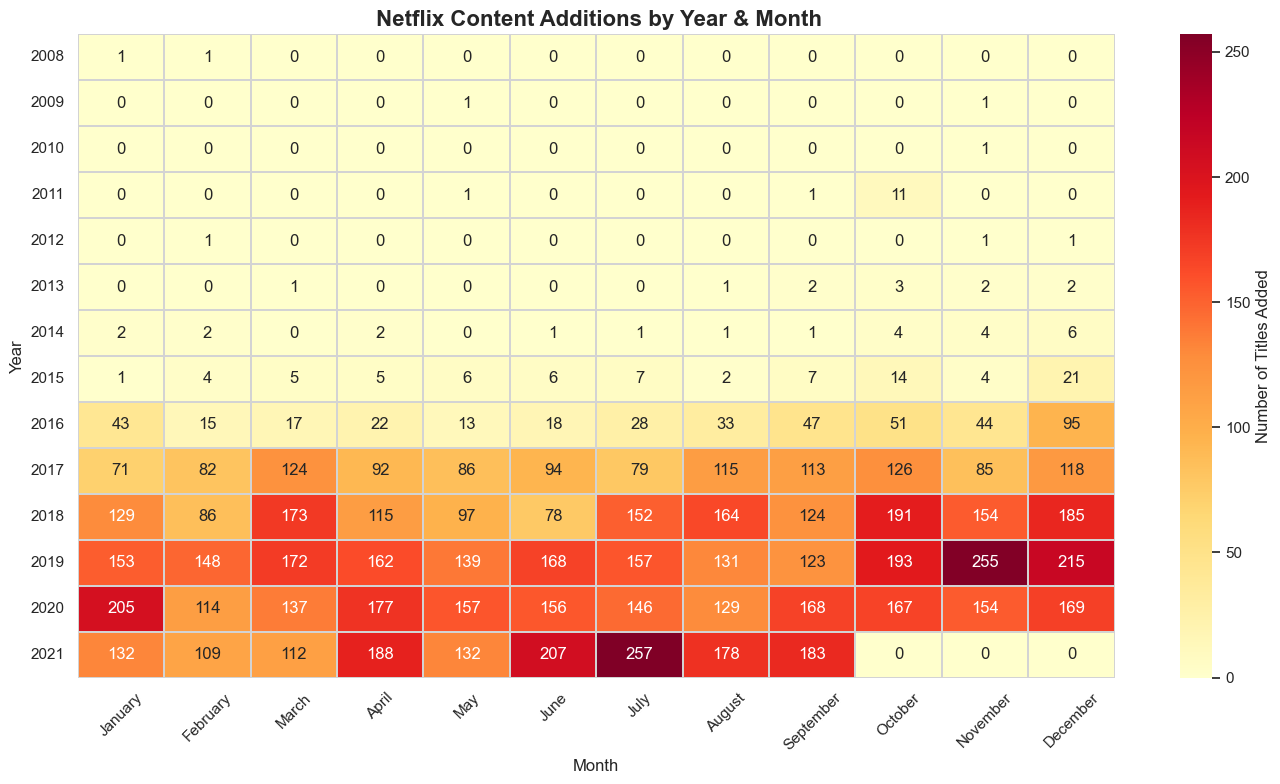

In [213]:

heatmap_data = df.groupby(["year_added", "month_added"]).size().unstack().fillna(0)

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
heatmap_data = heatmap_data[month_order]

# Plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    linewidths=0.3,
    linecolor='lightgrey',
    annot=True,
    fmt=".0f",
    cbar_kws={"label": "Number of Titles Added"}
)

plt.title(" Netflix Content Additions by Year & Month", fontsize=16, weight='bold')
plt.xlabel("Month")
plt.ylabel("Year")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
Are there countries that produce more shows than movies or vice versa?
</h3>


type            Movie  TV Show  Movie_ratio  TV Show_ratio
country                                                   
United States    2395      845     0.739198       0.260802
India             976       81     0.923368       0.076632
United Kingdom    387      251     0.606583       0.393417
Pakistan           71      350     0.168646       0.831354
Not Given         257       30     0.895470       0.104530
Canada            187       84     0.690037       0.309963
Japan              87      172     0.335907       0.664093
South Korea        49      165     0.228972       0.771028
France            148       65     0.694836       0.305164
Spain             129       53     0.708791       0.291209
Mexico             90       48     0.652174       0.347826
Egypt             109       14     0.886179       0.113821
Australia          61       53     0.535088       0.464912
Turkey             82       30     0.732143       0.267857
Nigeria            96        9     0.914286       0.0857

<Figure size 1200x800 with 0 Axes>

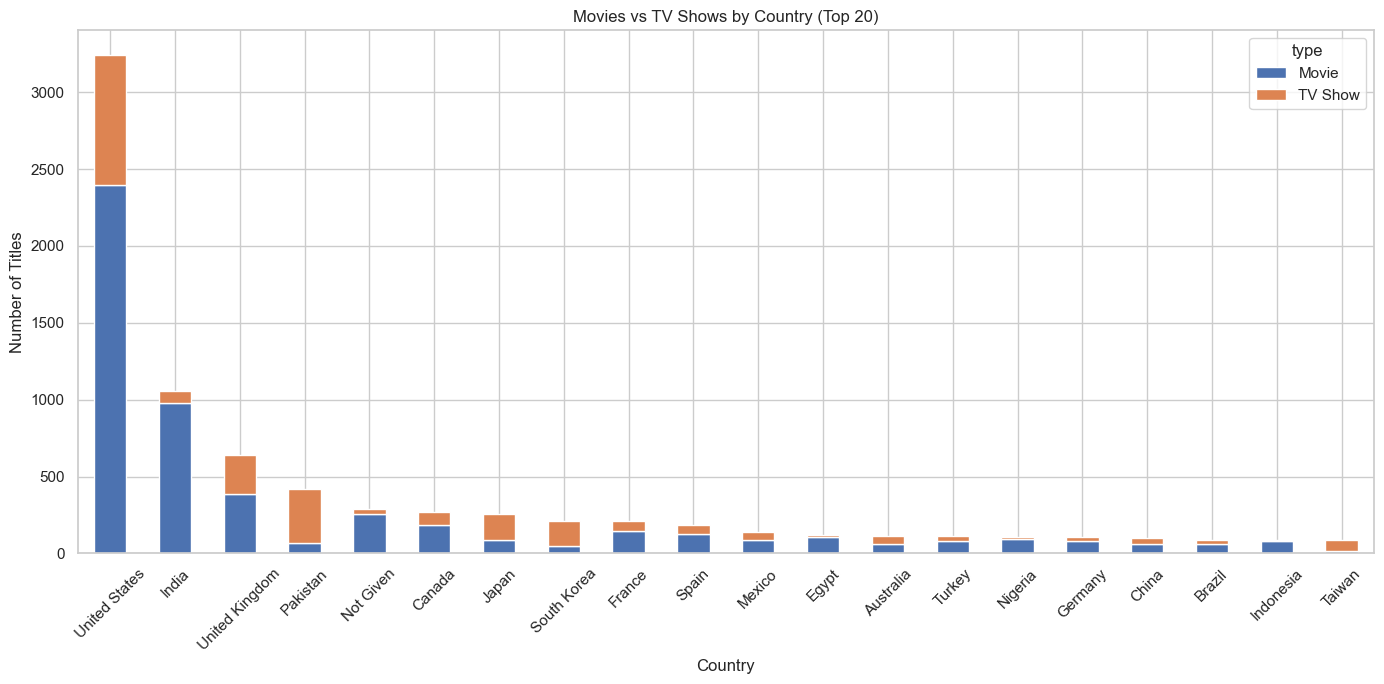

In [205]:

country_type_counts = df.groupby(['country', 'type']).size().unstack(fill_value=0)

country_type_counts['Total'] = country_type_counts.sum(axis=1)
country_type_counts['Movie_ratio'] = country_type_counts['Movie'] / country_type_counts['Total']
country_type_counts['TV Show_ratio'] = country_type_counts['TV Show'] / country_type_counts['Total']

significant_countries = country_type_counts[country_type_counts['Total'] >= 20]
significant_countries = significant_countries.sort_values('Total', ascending=False)

print(significant_countries[['Movie', 'TV Show', 'Movie_ratio', 'TV Show_ratio']].head(15))

plt.figure(figsize=(12, 8))


top_countries = significant_countries.head(20)

top_countries[['Movie', 'TV Show']].plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Movies vs TV Shows by Country (Top 20)')
plt.ylabel('Number of Titles')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<h2 style="color:black; font-family:'Times New Roman', Times, serif">
  Visualization 
</h2>


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
Count of Movies vs TV Shows
</h3>


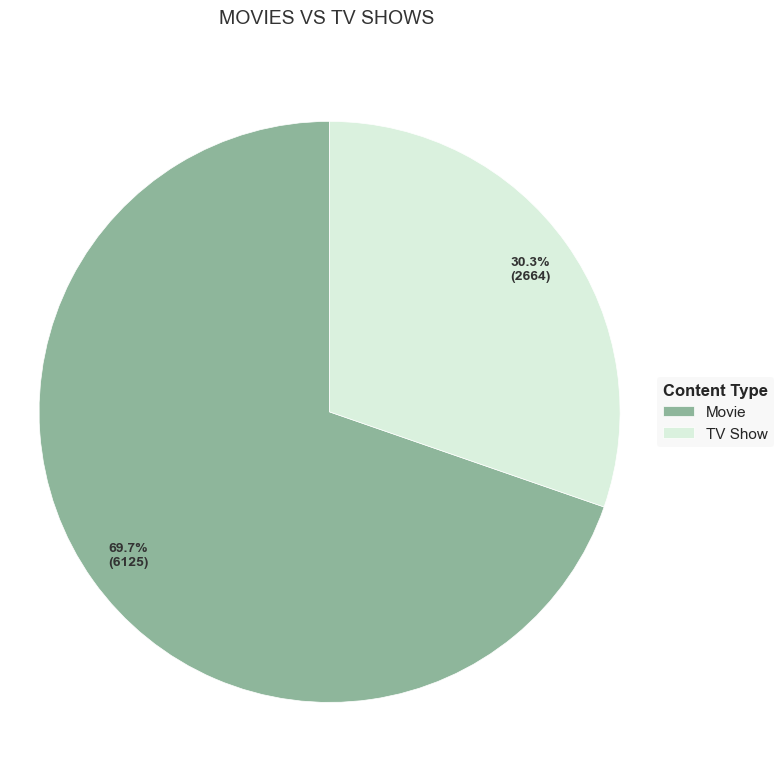

In [206]:

type_counts = df['type'].value_counts()

plt.figure(figsize=(8, 8), facecolor='white', dpi=100)

colors = ['#8EB69B', '#DAF1DE'] 

wedges, texts, autotexts = plt.pie(
    type_counts,
    labels=None,  
    colors=colors,
    autopct=lambda p: f'{p:.1f}%\n({int(p/100*type_counts.sum())})',
    startangle=90,
    wedgeprops={'linewidth': 0.5, 'edgecolor': 'white', 'linestyle': '-'},
    textprops={'fontsize': 10, 'fontweight': 'medium', 'color': '#333333',
               'fontfamily': 'sans-serif'},
    pctdistance=0.85 
)

for autotext in autotexts:
    autotext.set_fontweight('semibold')
    autotext.set_color('#333333')  # Dark gray for better contrast

legend = plt.legend(
    wedges,
    type_counts.index,
    title="Content Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=True,
    framealpha=0.9,
    edgecolor='none',
    facecolor='#F8F8F8',  # Very light gray background
    title_fontproperties={'weight': 'semibold'}
)

plt.title('MOVIES VS TV SHOWS ', 
          pad=20, 
          fontsize=14,
          fontweight='medium',
          color='#333333')

plt.axis('equal')


plt.gca().spines[:].set_visible(False)

plt.gca().set_facecolor('#FAFAFA')

plt.tight_layout()
plt.show()


<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Number of releases per year
</h3>


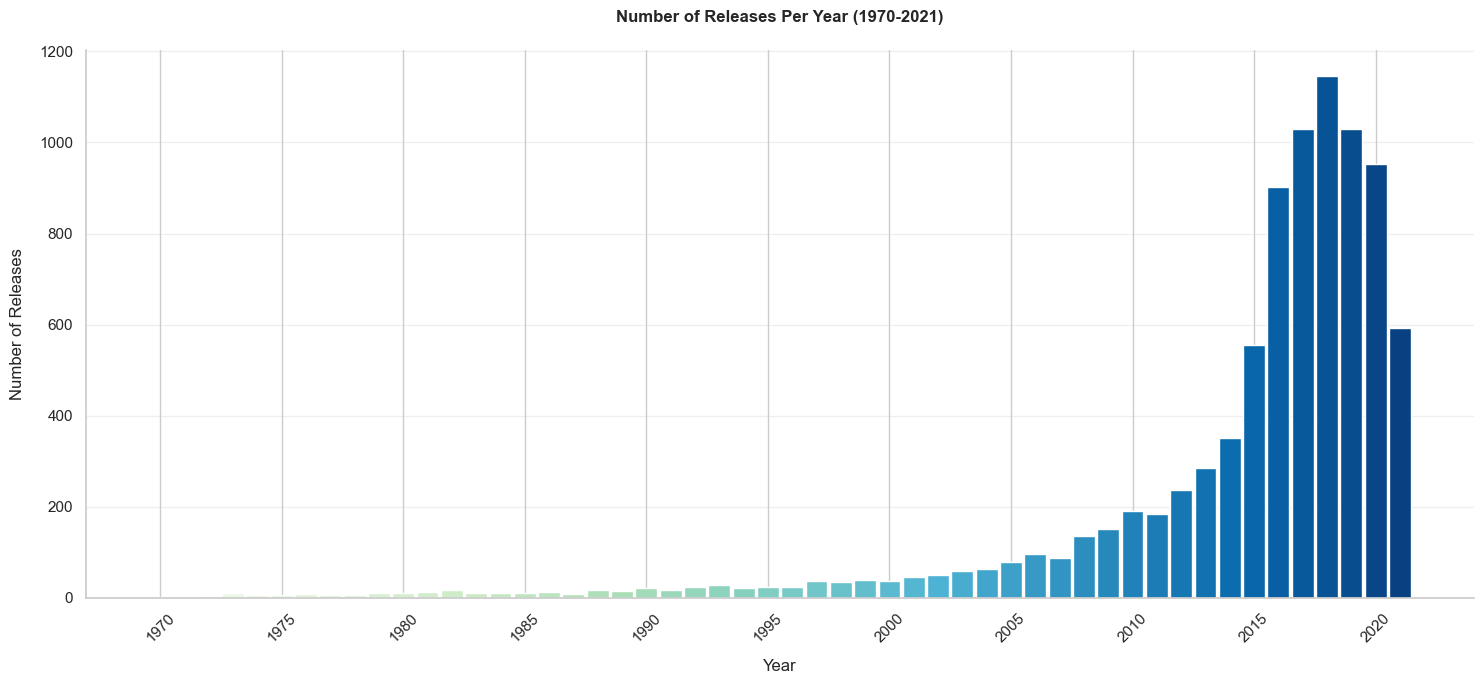

In [207]:

year_counts = df[df['release_year'] >= 1970]['release_year'].value_counts().sort_index()

plt.figure(figsize=(15, 7))

gradient = np.linspace(0, 1, len(year_counts))
colors = plt.cm.GnBu(gradient)  

bars = plt.bar(year_counts.index, year_counts.values, color=colors, width=0.9, edgecolor='white')

plt.grid(axis='y', alpha=0.3)
plt.xticks(np.arange(1970, max(year_counts.index)+1, 5), rotation=45)
plt.title('Number of Releases Per Year (1970-2021)', fontweight='bold', pad=20)
plt.xlabel('Year', labelpad=10)
plt.ylabel('Number of Releases', labelpad=10)


for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Top 10 countries by content count
</h3>


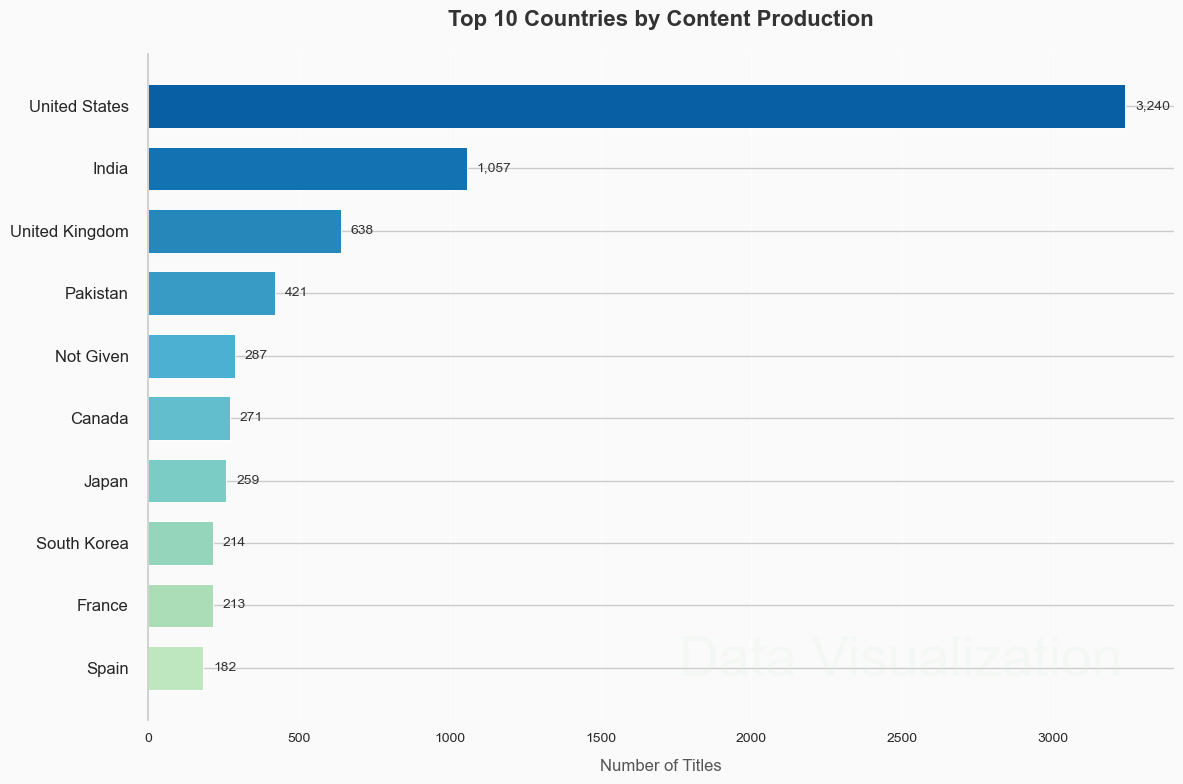

In [208]:

top_countries = df['country'].value_counts().head(10).sort_values()


plt.figure(figsize=(12, 8), facecolor='#FAFAFA')
ax = plt.axes(facecolor='#FAFAFA')


colors = plt.cm.GnBu(np.linspace(0.3, 0.9, len(top_countries)))


bars = ax.barh(top_countries.index, top_countries.values, 
               color=colors, 
               edgecolor='white', 
               linewidth=0.7,
               height=0.7)


for bar in bars:
    width = bar.get_width()
    ax.text(width + max(top_countries.values)*0.01, 
            bar.get_y() + bar.get_height()/2,
            f'{width:,}', 
            va='center', 
            ha='left',
            fontsize=10,
            color='#333333')


ax.spines[['top', 'right', 'bottom']].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.grid(axis='x', color='white', alpha=0.8)
ax.set_axisbelow(True)


plt.title('Top 10 Countries by Content Production', 
          pad=20, fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Number of Titles', labelpad=10, fontsize=12, color='#555555')


plt.ylabel('')
ax.tick_params(axis='y', which='major', pad=8, labelsize=12)
ax.xaxis.set_tick_params(labelsize=10)


plt.text(0.95, 0.05, 'Data Visualization', 
         transform=ax.transAxes, 
         fontsize=40, color='#DAF1DE', alpha=0.2,
         ha='right', va='bottom')

plt.tight_layout()
plt.show()

<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Content added per month (across years)
</h3>


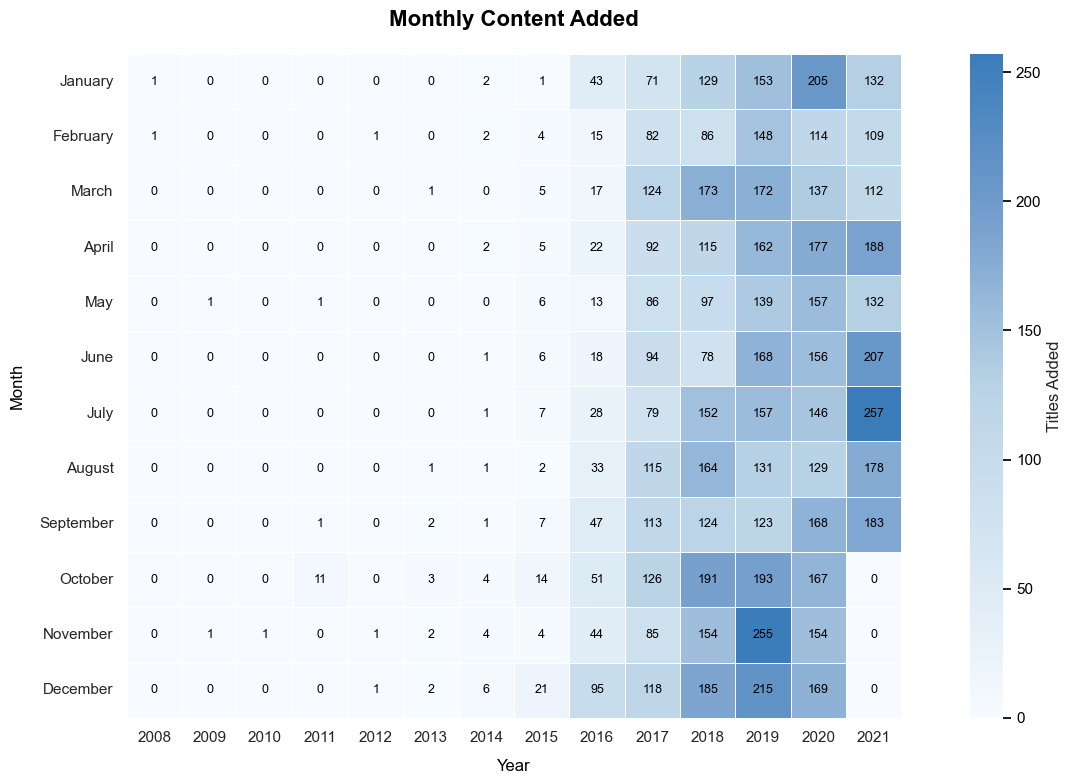

In [209]:

monthly_data = df.groupby(['year_added', 'month_added']).size().unstack().fillna(0)
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = monthly_data[month_order].T


cmap = mcolors.LinearSegmentedColormap.from_list("light_blue", 
                                               ["#F7FBFF", "#D6E6F2", "#B9D3E6", 
                                                "#769FCD", "#3A7CBA"])


plt.figure(figsize=(14, 8), facecolor='white')
ax = plt.axes(facecolor='white')


heatmap = sns.heatmap(heatmap_data,
                      cmap=cmap,
                      annot=True,
                      fmt="g",
                      linewidths=0.5,
                      linecolor='white',
                      cbar_kws={'label': 'Titles Added'},
                      annot_kws={'size': 9, 'color': 'black'},  # Black annotations
                      square=True)


cbar = heatmap.collections[0].colorbar
cbar.outline.set_edgecolor('#DDDDDD')
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


plt.title('Monthly Content Added', 
          pad=20, fontsize=16, fontweight='bold', color='black')
plt.xlabel('Year', labelpad=10, fontsize=12, color='black')
plt.ylabel('Month', labelpad=10, fontsize=12, color='black')


ax.hlines(np.arange(1,12), *ax.get_xlim(), color='white', linewidth=0.5)
ax.vlines(np.arange(1,len(heatmap_data.columns)), *ax.get_ylim(), color='white', linewidth=0.5)


plt.rcParams.update({
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

plt.tight_layout()
plt.show()

<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Content count by rating 
</h3>


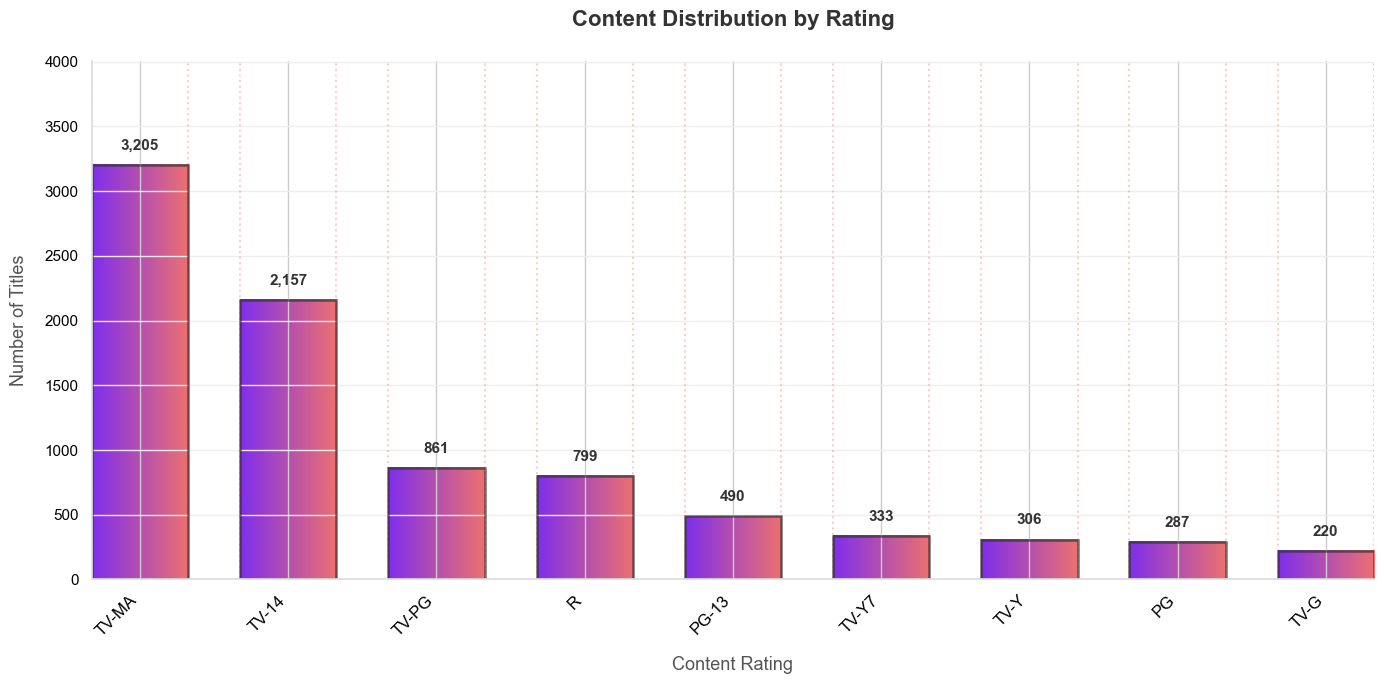

In [210]:


rating_counts = df['rating'].value_counts().sort_values(ascending=False)


common_ratings = ['TV-MA', 'TV-14', 'TV-PG', 'R', 'PG-13', 'PG', 'TV-G', 'TV-Y', 'TV-Y7']
rating_counts = rating_counts[rating_counts.index.isin(common_ratings)]

gradient_colors = ['#7117ea', '#ea6060']  # Purple to Coral
cmap = LinearSegmentedColormap.from_list("rating_gradient", gradient_colors)


plt.figure(figsize=(14, 7), facecolor='white')
ax = plt.axes(facecolor='white')


bar_width = 0.65 


for i, (rating, count) in enumerate(zip(rating_counts.index, rating_counts.values)):
   
    gradient = np.linspace(0, 1, 100).reshape(1, -1)
    ax.imshow(gradient, 
             extent=[i-bar_width/2, i+bar_width/2, 0, count],
             aspect='auto',
             cmap=cmap,
             alpha=0.9)
    ax.add_patch(plt.Rectangle(
        (i-bar_width/2, 0), bar_width, count,
        fill=False, edgecolor='#333333', lw=1.8, alpha=0.7
    ))
    
 
    ax.text(i, count + max(rating_counts.values)*0.03, 
            f'{count:,}',
            ha='center', va='bottom',
            fontsize=11, fontweight='bold', color='#333333')


for i in range(len(rating_counts)):
    ax.axvline(x=i-bar_width/2, color='red', alpha=0.2, linestyle=':')
    ax.axvline(x=i+bar_width/2, color='red', alpha=0.2, linestyle=':')


ax.set_xticks(np.arange(len(rating_counts)))
ax.set_xticklabels(rating_counts.index, rotation=45, ha='right', fontsize=12)
ax.set_ylim(0, max(rating_counts.values)*1.25)  # Extra headroom
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('#DDDDDD')
ax.grid(axis='y', color='#EEEEEE')


plt.title('Content Distribution by Rating', 
         pad=25, fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Content Rating', labelpad=12, fontsize=13, color='#555555')
plt.ylabel('Number of Titles', labelpad=12, fontsize=13, color='#555555')

plt.tight_layout()
plt.show()

<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
  Duration distribution of movies
</h3>


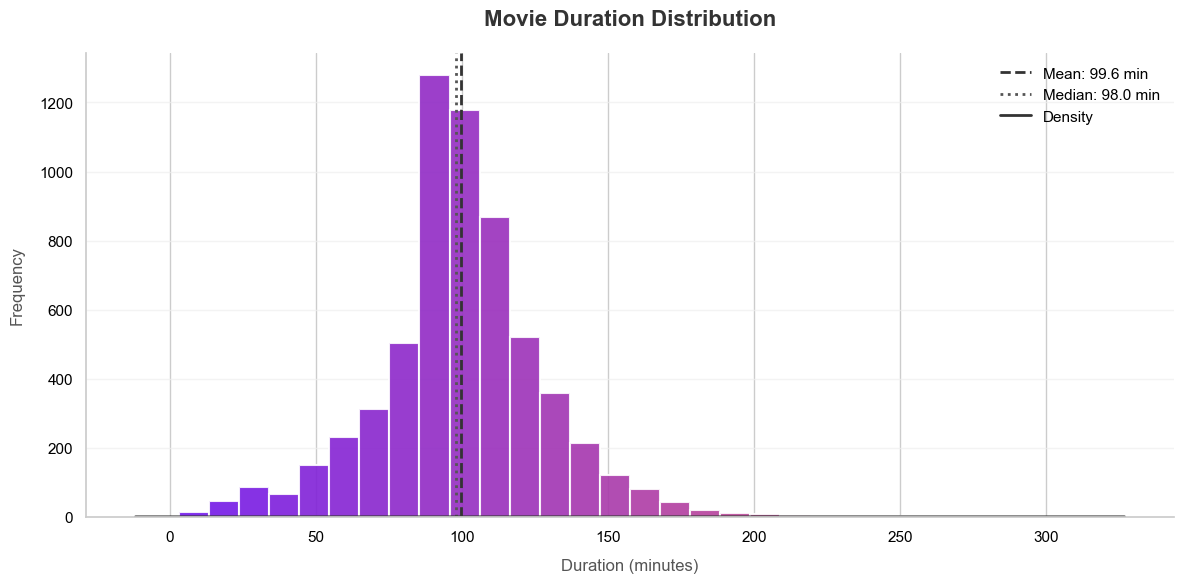

In [211]:


movies = df[df['type'] == 'Movie'].copy()


movies['duration_min'] = movies['duration'].str.extract(r'(\d+)').astype(float)  # Note the 'r' prefix


plt.figure(figsize=(12, 6), facecolor='white')
ax = plt.axes(facecolor='white')

gradient = LinearSegmentedColormap.from_list("movie_gradient", ["#7117ea", "#ea6060"])

q25, q75 = np.percentile(movies['duration_min'].dropna(), [25, 75])
bin_width = 2 * (q75 - q25) * len(movies['duration_min'].dropna())**(-1/3)
bins = int(np.ceil((movies['duration_min'].max() - movies['duration_min'].min()) / bin_width))


n, bins, patches = plt.hist(movies['duration_min'].dropna(),
                           bins=min(bins, 30),  
                           edgecolor='white',
                           linewidth=1.5,
                           alpha=0.9)


for i, patch in enumerate(patches):
    patch.set_facecolor(gradient(i/len(patches)))


mean_dur = movies['duration_min'].mean()
median_dur = movies['duration_min'].median()
plt.axvline(mean_dur, color='#333333', linestyle='--', 
            linewidth=2, label=f'Mean: {mean_dur:.1f} min')
plt.axvline(median_dur, color='#555555', linestyle=':', 
            linewidth=2, label=f'Median: {median_dur:.1f} min')


sns.kdeplot(movies['duration_min'].dropna(), 
            color='#333333', 
            linewidth=2,
            label='Density')


plt.title('Movie Duration Distribution', 
         pad=20, fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Duration (minutes)', labelpad=10, fontsize=12, color='#555555')
plt.ylabel('Frequency', labelpad=10, fontsize=12, color='#555555')
plt.grid(axis='y', color='#EEEEEE', alpha=0.7)
plt.legend(frameon=False)

sns.despine()
plt.tight_layout()
plt.show()

<h3 style="color:black; font-family:'Times New Roman', Times, serif; font-style:italic;">
 Year vs Genre trend 
</h3>


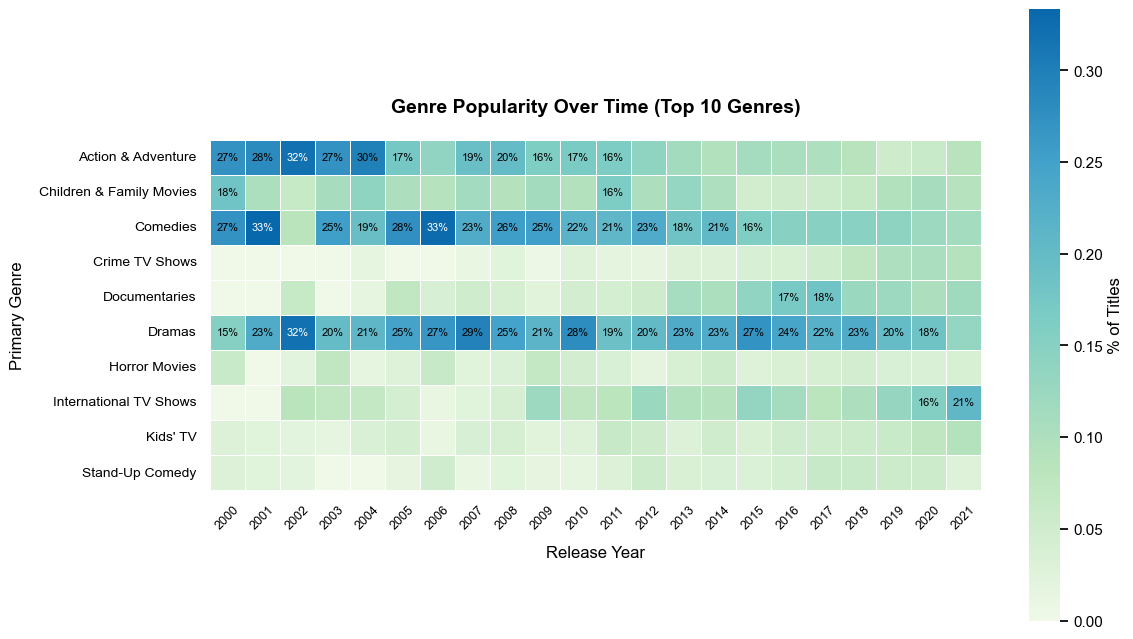

In [212]:

df['primary_genre'] = df['listed_in'].str.split(',').str[0].str.strip()


top_genres = df['primary_genre'].value_counts().nlargest(10).index


genre_year = (df[df['primary_genre'].isin(top_genres)]
              .groupby(['release_year', 'primary_genre'])
              .size()
              .unstack()
              .fillna(0)
              .loc[2000:] 
              )


heatmap_data = genre_year.div(genre_year.sum(axis=1), axis=0)


cmap = LinearSegmentedColormap.from_list("readable", 
                                       ["#f0f9e8", "#bae4bc", "#7bccc4", 
                                        "#43a2ca", "#0868ac"])


plt.figure(figsize=(12, 8), facecolor='white')
ax = sns.heatmap(
    heatmap_data.T,
    cmap=cmap,
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={'label': '% of Titles', 'shrink': 0.8},
    annot=False  
)


plt.title('Genre Popularity Over Time (Top 10 Genres)', 
         pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Release Year', labelpad=10)
plt.ylabel('Primary Genre', labelpad=10)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(fontsize=10)


for i in range(len(heatmap_data.columns)):
    for j in range(len(heatmap_data)):
        if heatmap_data.iloc[j, i] > 0.15:  # Only label cells >15%
            ax.text(j+0.5, i+0.5, f'{heatmap_data.iloc[j, i]:.0%}',
                   ha='center', va='center',
                   color='white' if heatmap_data.iloc[j, i] > 0.3 else 'black',
                   fontsize=8)

plt.tight_layout()
plt.show()